# ResNet Attention Fine-tuning Medical Model Testing

This notebook tests the trained ResNet attention-based fine-tuned medical CT-MRI fusion model with comprehensive evaluation metrics and visualizations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Tuple, Dict, Any
import sys
import nibabel as nib
from skimage import exposure, filters
import json
from pathlib import Path

# Add path to utils for metrics

from utils.metrics import evaluate_fusion_comprehensive, get_metric_descriptions

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Medical Image Preprocessing Utilities (same as training)
class MedicalImageProcessor:
    """Specialized preprocessing for medical images"""
    
    @staticmethod
    def load_dicom_or_nifti(filepath):
        """Load medical image from various formats"""
        filepath = str(filepath)
        
        if filepath.endswith('.nii') or filepath.endswith('.nii.gz'):
            # NIfTI format
            img = nib.load(filepath)
            data = img.get_fdata()
            # Take middle slice if 3D
            if len(data.shape) == 3:
                data = data[:, :, data.shape[2]//2]
            return data.astype(np.float32)
            
        elif filepath.endswith('.dcm'):
            # DICOM format (requires pydicom)
            try:
                import pydicom
                ds = pydicom.dcmread(filepath)
                data = ds.pixel_array.astype(np.float32)
                return data
            except ImportError:
                print("Warning: pydicom not installed, falling back to image loader")
                
        # Fall back to regular image formats
        img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        if img is None:
            img = np.array(Image.open(filepath).convert('L'))
        return img.astype(np.float32)
    
    @staticmethod
    def apply_ct_windowing(img, center=40, width=400):
        """Apply CT windowing (HU units)"""
        min_val = center - width // 2
        max_val = center + width // 2
        img = np.clip(img, min_val, max_val)
        img = (img - min_val) / (max_val - min_val)
        return img
    
    @staticmethod
    def normalize_medical_image(img, modality='CT'):
        """Normalize medical image intensities"""
        if modality.upper() == 'CT':
            # CT images might be in HU units
            if img.min() < -500:  # Likely HU units
                img = MedicalImageProcessor.apply_ct_windowing(
                    img, 40, 400  # Default values
                )
            else:
                # Already normalized or different scale
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        else:
            # MRI - simple min-max normalization
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            
        return img
    
    @staticmethod
    def enhance_medical_contrast(img):
        """Enhance contrast for better fusion"""
        # Ensure image is in correct format for CLAHE
        if img.dtype != np.float32:
            img = img.astype(np.float32)
        
        # Handle multi-channel images by converting to grayscale
        if len(img.shape) > 2:
            img = np.mean(img, axis=-1)
        
        # Ensure values are in [0, 1] range
        img = np.clip(img, 0, 1)
        
        # Convert to uint8 for CLAHE
        img_uint8 = (img * 255).astype(np.uint8)
        
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img_uint8)
        
        # Convert back to float32 in [0, 1] range
        return enhanced.astype(np.float32) / 255.0
    
    @staticmethod
    def prepare_medical_image(img, modality='CT'):
        """Complete preprocessing pipeline"""
        # Normalize intensities
        img = MedicalImageProcessor.normalize_medical_image(img, modality)
        
        # Enhance contrast
        img = MedicalImageProcessor.enhance_medical_contrast(img)
            
        return img

In [3]:
# Medical Fusion Model Architecture (same as training)
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        attention = self.conv(x)
        attention = self.sigmoid(attention)
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DualAttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention(channels)
        
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, vis_feat, ir_feat):
        vis_att = self.spatial_attention(self.channel_attention(vis_feat))
        ir_att = self.spatial_attention(self.channel_attention(ir_feat))
        
        combined = torch.cat([vis_att, ir_att], dim=1)
        fused = self.fusion_conv(combined)
        
        return fused

class MedicalFusionModel(nn.Module):
    """Adapted model for medical CT-MRI fusion"""
    def __init__(self):
        super().__init__()
        
        # Same architecture as ImprovedFusionModel but with medical adaptations
        backbone = models.resnet34(pretrained=True)
        
        # CT encoder (was visible encoder)
        self.ct_stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.ct_layer1 = backbone.layer1
        self.ct_layer2 = backbone.layer2
        self.ct_layer3 = backbone.layer3
        self.ct_layer4 = backbone.layer4
        
        # MRI encoder (was IR encoder) 
        mri_backbone = models.resnet34(pretrained=True)
        old_conv1 = mri_backbone.conv1
        mri_backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            mri_backbone.conv1.weight = nn.Parameter(old_conv1.weight.mean(dim=1, keepdim=True))
            
        self.mri_stem = nn.Sequential(
            mri_backbone.conv1,
            mri_backbone.bn1,
            mri_backbone.relu,
            mri_backbone.maxpool
        )
        self.mri_layer1 = mri_backbone.layer1
        self.mri_layer2 = mri_backbone.layer2
        self.mri_layer3 = mri_backbone.layer3
        self.mri_layer4 = mri_backbone.layer4
        
        # Fusion blocks
        self.fusion1 = DualAttentionFusion(64)
        self.fusion2 = DualAttentionFusion(128)
        self.fusion3 = DualAttentionFusion(256)
        self.fusion4 = DualAttentionFusion(512)
        
        # Decoder with medical-specific modifications
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Final layer for medical fusion
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()  # Output in [0,1] for medical images
        )
        
        # Medical-specific attention layer
        self.medical_attention = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()
        )
        
    def forward(self, ct, mri):
        # Encode CT (3-channel)
        c0 = self.ct_stem(ct)
        c1 = self.ct_layer1(c0)
        c2 = self.ct_layer2(c1)
        c3 = self.ct_layer3(c2)
        c4 = self.ct_layer4(c3)
        
        # Encode MRI (1-channel)
        m0 = self.mri_stem(mri)
        m1 = self.mri_layer1(m0)
        m2 = self.mri_layer2(m1)
        m3 = self.mri_layer3(m2)
        m4 = self.mri_layer4(m3)
        
        # Fuse at each level
        f1 = self.fusion1(c1, m1)
        f2 = self.fusion2(c2, m2)
        f3 = self.fusion3(c3, m3)
        f4 = self.fusion4(c4, m4)
        
        # Decode
        d4 = self.decoder4(f4)
        d3 = self.decoder3(torch.cat([d4, f3], dim=1))
        d2 = self.decoder2(torch.cat([d3, f2], dim=1))
        d1 = self.decoder1(torch.cat([d2, f1], dim=1))
        
        output = self.final(d1)
        
        # Apply medical attention
        attention = self.medical_attention(output)
        output = output * attention
        
        return output

In [4]:
# Medical Fusion Dataset (same as training)
class MedicalFusionDataset(Dataset):
    """Dataset for CT-MRI fusion"""
    
    def __init__(self, ct_path, mri_path, train=True, split_ratio=0.8):
        self.ct_path = Path(ct_path).resolve()  # Use absolute path
        self.mri_path = Path(mri_path).resolve()  # Use absolute path
        self.train = train
        self.split_ratio = split_ratio
        
        print(f"CT path: {self.ct_path}")
        print(f"MRI path: {self.mri_path}")
        print(f"CT path exists: {self.ct_path.exists()}")
        print(f"MRI path exists: {self.mri_path.exists()}")
        
        # Find matching CT-MRI pairs
        all_pairs = self._find_image_pairs()
        
        print(f"Found {len(all_pairs)} total pairs before split")
        
        # Split into train/val based on split_ratio
        if len(all_pairs) > 0:
            split_idx = int(len(all_pairs) * self.split_ratio)
            if self.train:
                self.pairs = all_pairs[:split_idx]
            else:
                self.pairs = all_pairs[split_idx:]
        else:
            self.pairs = []
            
        print(f"Found {len(self.pairs)} CT-MRI pairs in {'train' if train else 'validation'} set (from {len(all_pairs)} total pairs)")
        
        # Medical image transforms
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
    
    def _find_image_pairs(self):
        """Find matching CT-MRI image pairs"""
        print("Finding image pairs...")
        
        ct_files = list(self.ct_path.glob('*'))
        mri_files = list(self.mri_path.glob('*'))
        
        print(f"CT glob found {len(ct_files)} files")
        print(f"MRI glob found {len(mri_files)} files")
        
        ct_files = [f for f in ct_files if f.suffix.lower() in 
                   ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.nii', '.dcm', '.nii.gz']]
        mri_files = [f for f in mri_files if f.suffix.lower() in 
                    ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.nii', '.dcm', '.nii.gz']]
        
        print(f"CT files after filtering: {len(ct_files)}")
        print(f"MRI files after filtering: {len(mri_files)}")
        
        if ct_files:
            print(f"First CT file: {ct_files[0]}")
        if mri_files:
            print(f"First MRI file: {mri_files[0]}")
        
        # Match by filename (without extension)
        ct_names = {f.stem.split('.')[0]: f for f in ct_files}  # Handle .nii.gz
        mri_names = {f.stem.split('.')[0]: f for f in mri_files}
        
        print(f"CT name keys (first 5): {list(ct_names.keys())[:5]}")
        print(f"MRI name keys (first 5): {list(mri_names.keys())[:5]}")
        
        pairs = []
        for name in ct_names.keys():
            if name in mri_names:
                pairs.append((ct_names[name], mri_names[name]))
        
        print(f"Found {len(pairs)} matching pairs")
        return pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        ct_path, mri_path = self.pairs[idx]
        
        # Load medical images
        ct_img = MedicalImageProcessor.load_dicom_or_nifti(ct_path)
        mri_img = MedicalImageProcessor.load_dicom_or_nifti(mri_path)
        
        # Preprocess
        ct_img = MedicalImageProcessor.prepare_medical_image(ct_img, 'CT')
        mri_img = MedicalImageProcessor.prepare_medical_image(mri_img, 'MRI')
        
        # Ensure images are 2D
        if len(ct_img.shape) > 2:
            ct_img = ct_img.squeeze()
        if len(mri_img.shape) > 2:
            mri_img = mri_img.squeeze()
        
        # Handle different image sizes by cropping/padding to square
        ct_img = self._make_square(ct_img)
        mri_img = self._make_square(mri_img)
        
        # Apply transforms
        ct_tensor = self.transform(ct_img)
        mri_tensor = self.transform(mri_img)
        
        # Convert CT to 3-channel (like RGB), keep MRI as 1-channel (like IR)
        if ct_tensor.shape[0] == 1:
            ct_tensor = ct_tensor.repeat(3, 1, 1)
        
        return ct_tensor, mri_tensor, ct_path.name
    
    def _make_square(self, img):
        """Make image square by cropping or padding"""
        h, w = img.shape
        size = min(h, w)
        
        # Crop to square
        start_h = (h - size) // 2
        start_w = (w - size) // 2
        img = img[start_h:start_h+size, start_w:start_w+size]
        
        return img

In [5]:
# Configuration
ct_dir = '../Dataset/test/CT'
mri_dir = '../Dataset/test/MRI'
checkpoint_path = 'checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth'
results_dir = 'test_results/medical_fusion_finetuning'
batch_size = 2  # Smaller batch for medical images

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load trained model
print("Loading trained Medical Fusion Fine-tuning model...")
model = MedicalFusionModel().to(device)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded model from: {checkpoint_path}")
    print(f"  - Trained for {checkpoint.get('epoch', 'N/A')} epochs")
    print(f"  - Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
    print(f"  - Pretrained from: {checkpoint.get('pretrained_from', 'N/A')}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    print("Using untrained model for demonstration")

model.eval()

Loading trained Medical Fusion Fine-tuning model...


/mnt/Work/conda/installation/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/Work/conda/installation/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Loaded model from: checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
  - Trained for 19 epochs
  - Best validation loss: 4.9070
  - Pretrained from: pretrained/pretrained.pth


MedicalFusionModel(
  (ct_stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (ct_layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [6]:
# Prepare test dataset
print("Preparing test dataset...")
print(f"CT directory: {ct_dir}")
print(f"MRI directory: {mri_dir}")

# Check if directories exist
import os
print(f"CT directory exists: {os.path.exists(ct_dir)}")
print(f"MRI directory exists: {os.path.exists(ct_dir)}")

if os.path.exists(ct_dir):
    ct_files = os.listdir(ct_dir)
    print(f"CT files found: {len(ct_files)}")
    print(f"First 5 CT files: {ct_files[:5]}")

if os.path.exists(mri_dir):
    mri_files = os.listdir(mri_dir)
    print(f"MRI files found: {len(mri_files)}")
    print(f"First 5 MRI files: {mri_files[:5]}")

# For testing, use all data (set train=True to get all pairs)
test_dataset = MedicalFusionDataset(ct_dir, mri_dir, train=True, split_ratio=1.0)  # Use all test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

# Function to run inference on test set
def run_inference(model, test_loader, device):
    """Run inference on test set and collect results."""
    model.eval()
    results = []
    
    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)
            
            # Forward pass
            fused_batch = model(ct_batch, mr_batch)
            
            # Convert to numpy for metrics calculation
            for i in range(len(keys)):
                ct_np = ct_batch[i].permute(1, 2, 0).cpu().numpy()
                mr_np = mr_batch[i, 0].cpu().numpy()
                fused_np = fused_batch[i].permute(1, 2, 0).cpu().numpy()
                
                # Convert to grayscale for evaluation
                ct_gray = np.mean(ct_np, axis=2) if ct_np.shape[2] > 1 else ct_np.squeeze()
                fused_gray = np.mean(fused_np, axis=2) if fused_np.shape[2] > 1 else fused_np.squeeze()
                
                results.append({
                    'key': keys[i],
                    'ct': ct_gray,
                    'mr': mr_np,
                    'fused': fused_gray,
                    'ct_rgb': ct_np,
                    'fused_rgb': fused_np
                })
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    return results

# Run inference
print("Running inference on test set...")
test_results = run_inference(model, test_loader, device)
print(f"✓ Inference completed. Processed {len(test_results)} image pairs.")

Preparing test dataset...
CT directory: ../Dataset/test/CT
MRI directory: ../Dataset/test/MRI
CT directory exists: True
MRI directory exists: True
CT files found: 58
First 5 CT files: ['00020.png', '00001.png', '00002.png', '00003.png', '00004.png']
MRI files found: 58
First 5 MRI files: ['00020.png', '00001.png', '00002.png', '00003.png', '00004.png']
CT path: /mnt/Work/ML/trainable-multimodal-fusion/Dataset/test/CT
MRI path: /mnt/Work/ML/trainable-multimodal-fusion/Dataset/test/MRI
CT path exists: True
MRI path exists: True
Finding image pairs...
CT glob found 58 files
MRI glob found 58 files
CT files after filtering: 58
MRI files after filtering: 58
First CT file: /mnt/Work/ML/trainable-multimodal-fusion/Dataset/test/CT/00020.png
First MRI file: /mnt/Work/ML/trainable-multimodal-fusion/Dataset/test/MRI/00020.png
CT name keys (first 5): ['00020', '00001', '00002', '00003', '00004']
MRI name keys (first 5): ['00020', '00001', '00002', '00003', '00004']
Found 58 matching pairs
Found 58

In [7]:
# Calculate comprehensive metrics
print("Calculating evaluation metrics...")

all_metrics = []
for i, result in enumerate(test_results):
    # Debug: Check if images are valid
    print(f"Sample {i}: CT shape: {result['ct'].shape}, MRI shape: {result['mr'].shape}, Fused shape: {result['fused'].shape}")
    print(f"CT range: [{result['ct'].min():.3f}, {result['ct'].max():.3f}]")
    print(f"MRI range: [{result['mr'].min():.3f}, {result['mr'].max():.3f}]")
    print(f"Fused range: [{result['fused'].min():.3f}, {result['fused'].max():.3f}]")
    
    # Check for NaN or inf values
    if np.any(np.isnan(result['ct'])) or np.any(np.isnan(result['mr'])) or np.any(np.isnan(result['fused'])):
        print(f"Warning: NaN values found in sample {i}")
    if np.any(np.isinf(result['ct'])) or np.any(np.isinf(result['mr'])) or np.any(np.isinf(result['fused'])):
        print(f"Warning: Inf values found in sample {i}")
    
    metrics = evaluate_fusion_comprehensive(
        result['fused'], 
        result['ct'], 
        result['mr']
    )
    
    print(f"Metrics keys: {list(metrics.keys())}")
    print(f"Number of metrics: {len(metrics)}")
    
    if not metrics:
        print(f"ERROR: No metrics calculated for sample {i}")
        continue
        
    metrics['sample_id'] = i
    metrics['key'] = result['key']
    all_metrics.append(metrics)
    
    if (i + 1) % 20 == 0:
        print(f"Calculated metrics for {i + 1}/{len(test_results)} samples")

# Convert to DataFrame for analysis
if not all_metrics:
    print("ERROR: No metrics were calculated! Check the images and model output.")
    print("Debugging information:")
    print(f"Number of test results: {len(test_results)}")
    if test_results:
        print(f"Sample result keys: {list(test_results[0].keys())}")
else:
    metrics_df = pd.DataFrame(all_metrics)
    print(f"✓ Metrics calculated for {len(all_metrics)} samples")

Calculating evaluation metrics...
Sample 0: CT shape: (256, 256), MRI shape: (256, 256), Fused shape: (256, 256)
CT range: [0.008, 1.000]
MRI range: [0.008, 0.973]
Fused range: [0.006, 0.962]
Metrics keys: ['SSIM_CT', 'SSIM_MRI', 'SSIM_Avg', 'PSNR_CT', 'PSNR_MRI', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'Entropy_CT', 'Entropy_MRI', 'MI_CT', 'MI_MRI', 'MI_Avg', 'Std_Dev', 'Mean_Gradient', 'Mean', 'Min', 'Max']
Number of metrics: 18
Sample 1: CT shape: (256, 256), MRI shape: (256, 256), Fused shape: (256, 256)
CT range: [0.008, 1.000]
MRI range: [0.008, 0.976]
Fused range: [0.006, 0.965]
Metrics keys: ['SSIM_CT', 'SSIM_MRI', 'SSIM_Avg', 'PSNR_CT', 'PSNR_MRI', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'Entropy_CT', 'Entropy_MRI', 'MI_CT', 'MI_MRI', 'MI_Avg', 'Std_Dev', 'Mean_Gradient', 'Mean', 'Min', 'Max']
Number of metrics: 18
Sample 2: CT shape: (256, 256), MRI shape: (256, 256), Fused shape: (256, 256)
CT range: [0.008, 1.000]
MRI range: [0.008, 1.000]
Fused range: [0.002, 0.969

Generating visualizations...


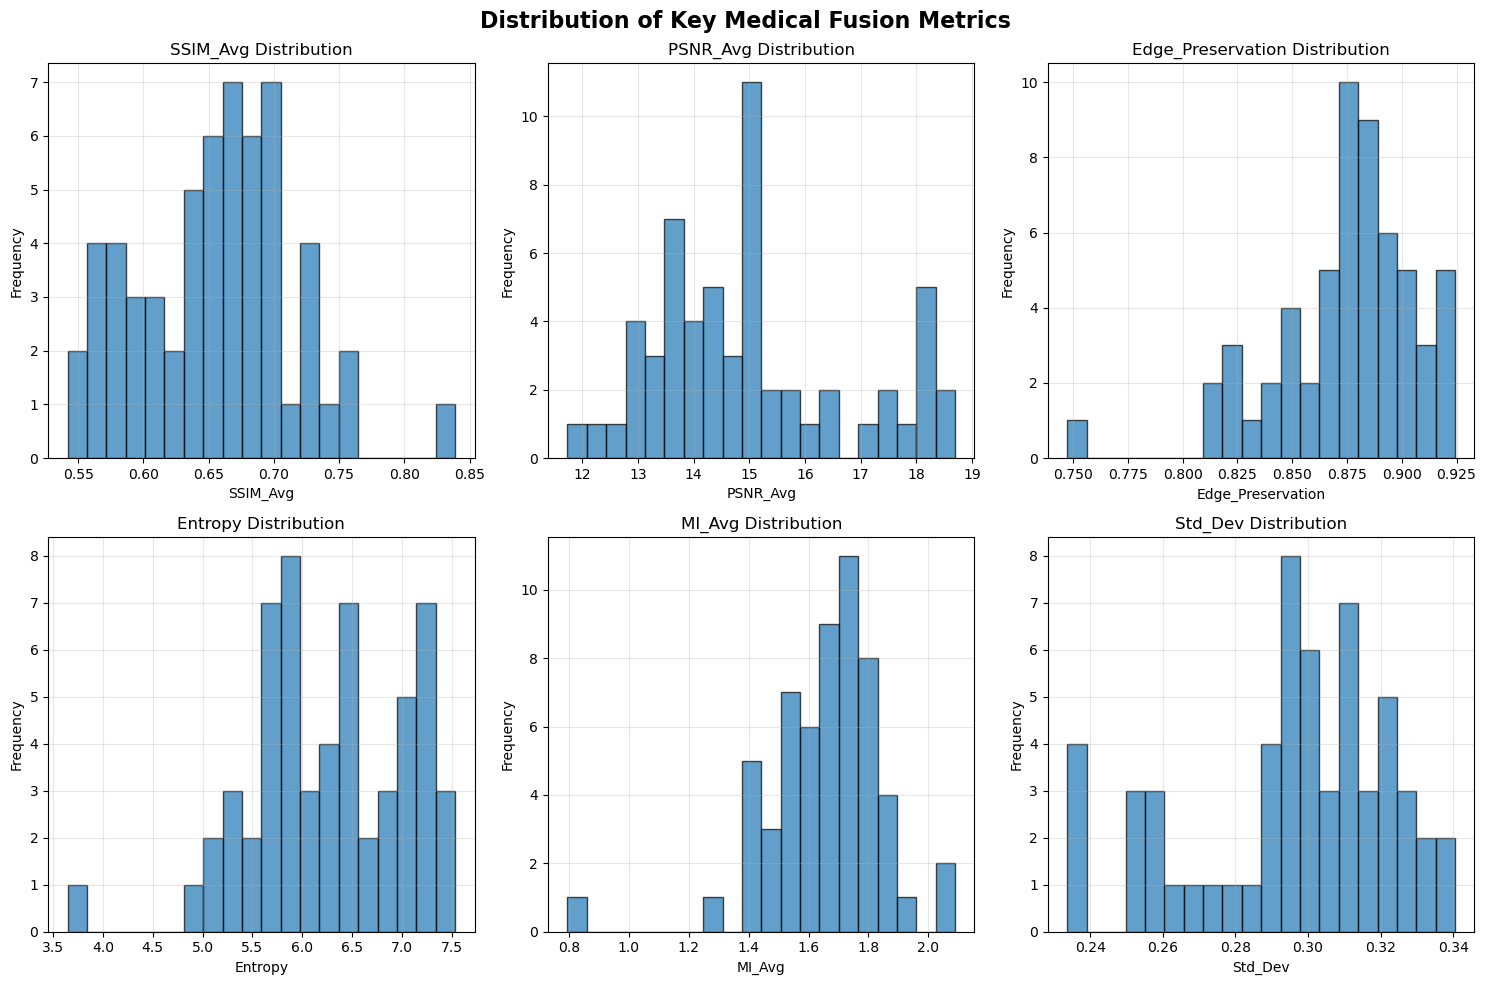

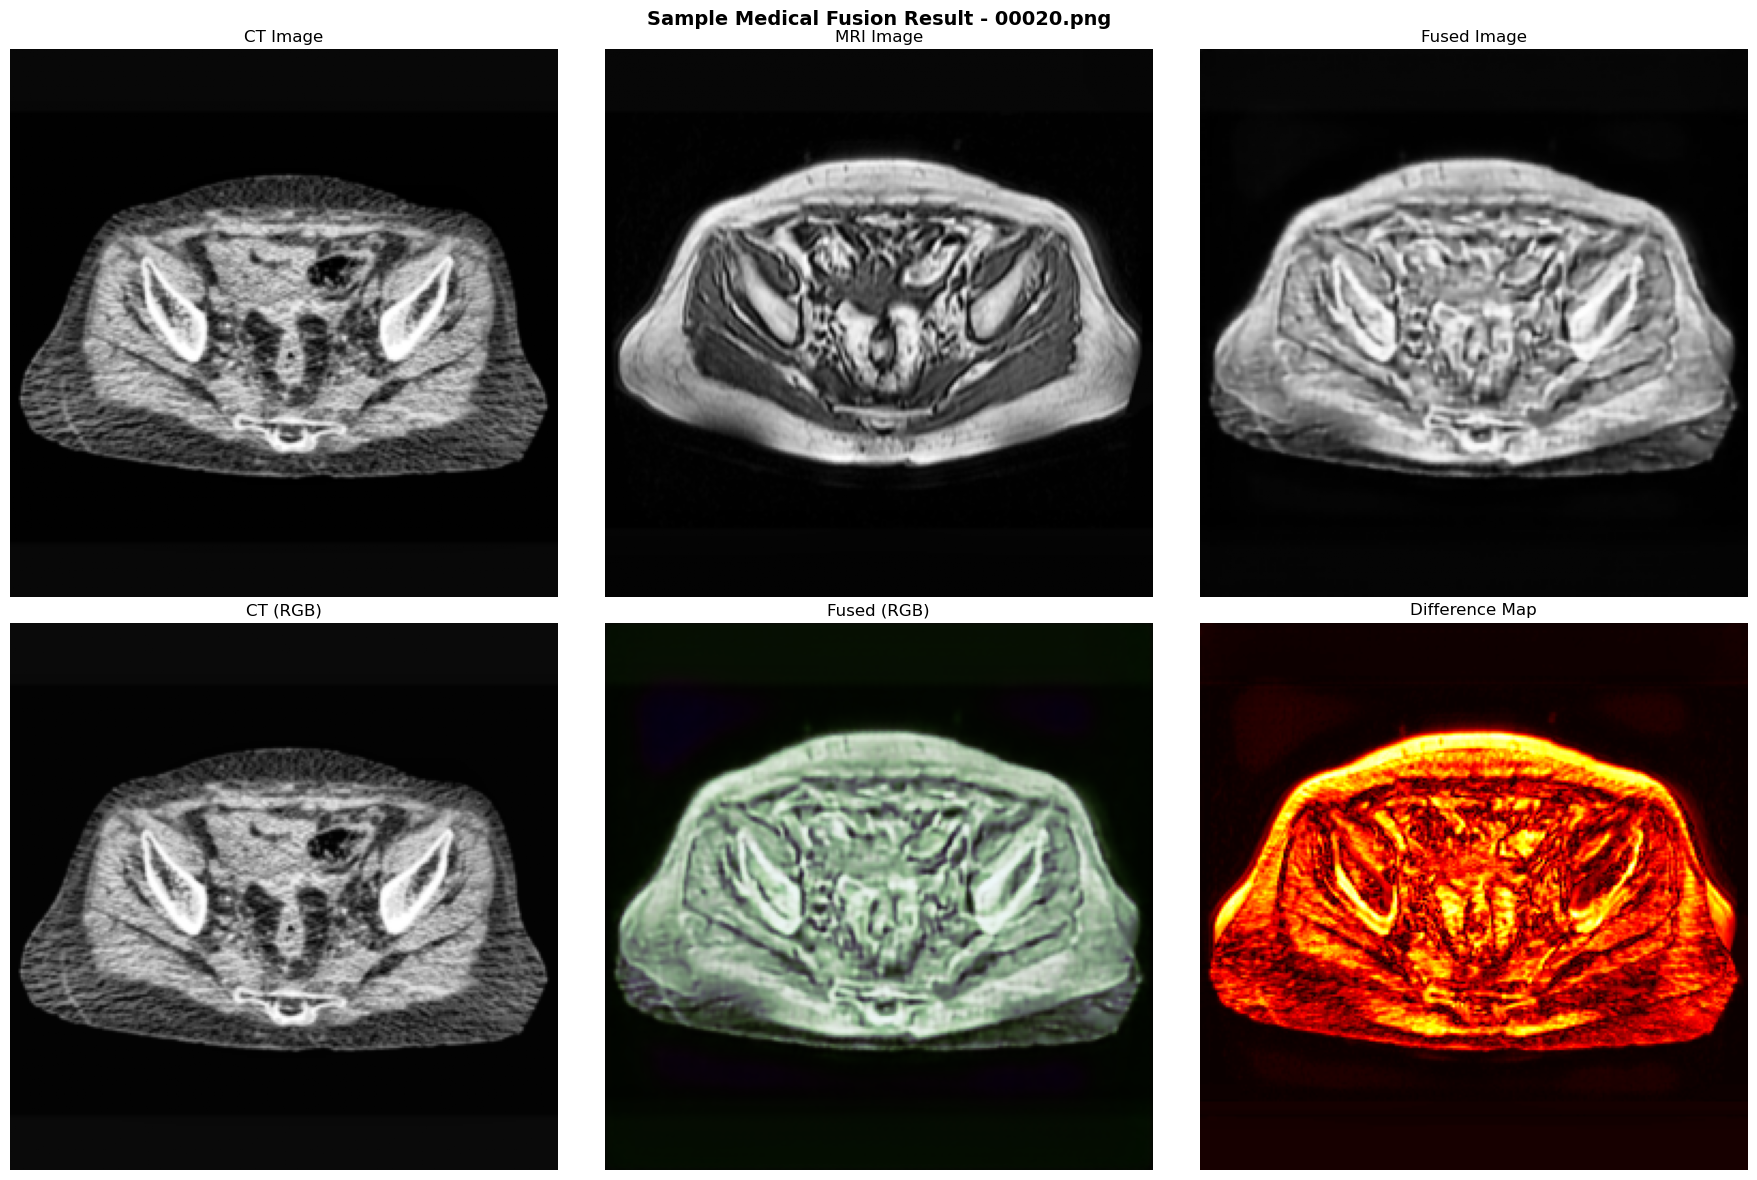


Metrics for sample 0 (00020.png):
----------------------------------------
SSIM_Avg       : 0.7041
PSNR_Avg       : 15.7380
Edge_Preservation: 0.8816
Entropy        : 6.0746
MI_Avg         : 1.9200
Std_Dev        : 0.2968


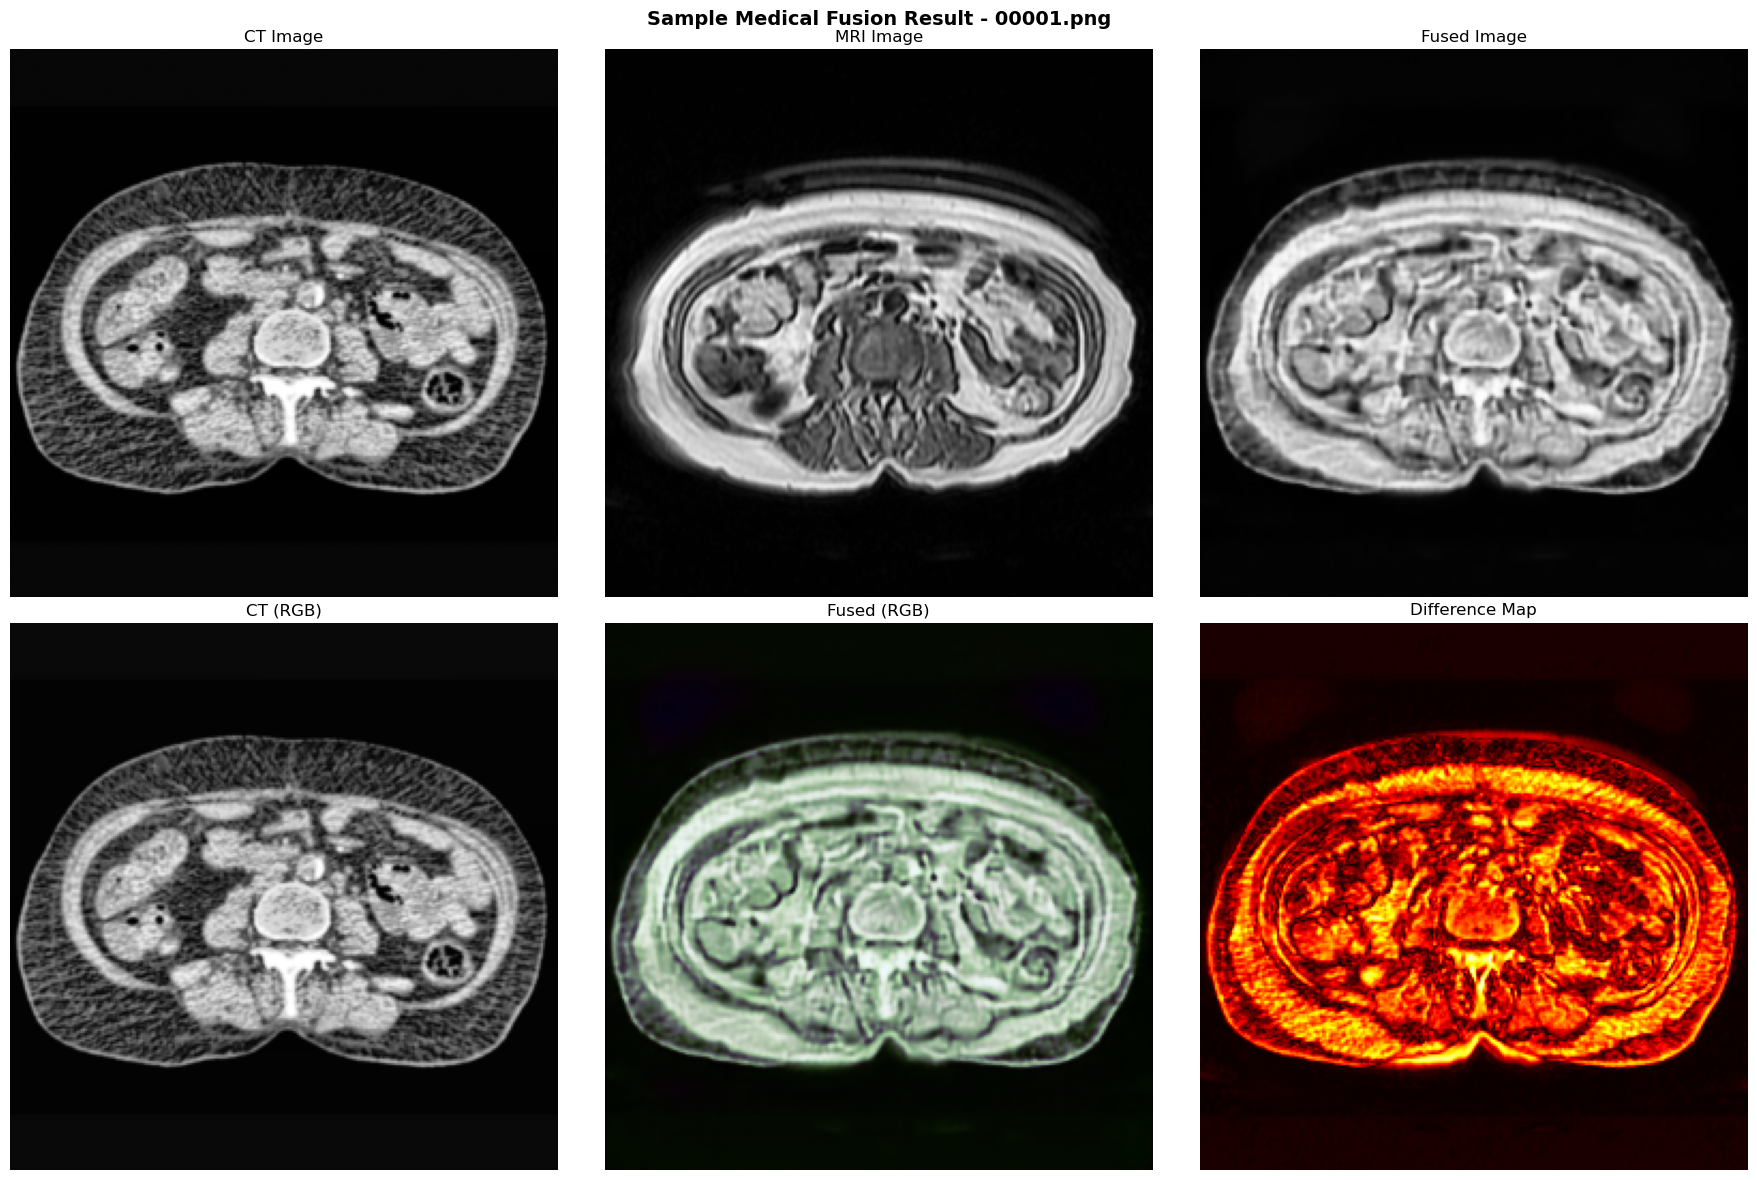


Metrics for sample 1 (00001.png):
----------------------------------------
SSIM_Avg       : 0.6872
PSNR_Avg       : 15.7847
Edge_Preservation: 0.8779
Entropy        : 6.1224
MI_Avg         : 1.8362
Std_Dev        : 0.3088



Metrics for sample 2 (00002.png):
----------------------------------------
SSIM_Avg       : 0.6726
PSNR_Avg       : 12.9812
Edge_Preservation: 0.8763
Entropy        : 5.8442
MI_Avg         : 1.4649
Std_Dev        : 0.3128


In [8]:
# Visualization of Results
print("Generating visualizations...")

# 1. Metrics Distribution Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Medical Fusion Metrics', fontsize=16, fontweight='bold')

key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev']
for i, metric in enumerate(key_metrics):
    ax = axes[i//3, i%3]
    ax.hist(metrics_df[metric], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Distribution')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'medical_metrics_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Sample Medical Fusion Results Visualization
def visualize_sample_medical_fusion(sample_idx=0):
    """Visualize a sample medical fusion result."""
    if sample_idx >= len(test_results):
        print(f"Sample index {sample_idx} out of range. Max: {len(test_results)-1}")
        return
    
    sample = test_results[sample_idx]
    metrics = all_metrics[sample_idx]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Sample Medical Fusion Result - {sample["key"]}', fontsize=14, fontweight='bold')
    
    # CT image
    axes[0, 0].imshow(sample['ct'], cmap='gray')
    axes[0, 0].set_title('CT Image')
    axes[0, 0].axis('off')
    
    # MRI image
    axes[0, 1].imshow(sample['mr'], cmap='gray')
    axes[0, 1].set_title('MRI Image')
    axes[0, 1].axis('off')
    
    # Fused image
    axes[0, 2].imshow(sample['fused'], cmap='gray')
    axes[0, 2].set_title('Fused Image')
    axes[0, 2].axis('off')
    
    # CT RGB
    axes[1, 0].imshow(sample['ct_rgb'])
    axes[1, 0].set_title('CT (RGB)')
    axes[1, 0].axis('off')
    
    # Fused RGB
    axes[1, 1].imshow(sample['fused_rgb'])
    axes[1, 1].set_title('Fused (RGB)')
    axes[1, 1].axis('off')
    
    # Difference map
    diff_ct = np.abs(sample['fused'] - sample['ct'])
    diff_mri = np.abs(sample['fused'] - sample['mr'])
    diff_combined = (diff_ct + diff_mri) / 2
    axes[1, 2].imshow(diff_combined, cmap='hot')
    axes[1, 2].set_title('Difference Map')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'sample_medical_fusion_{sample_idx}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print metrics for this sample
    print(f"\nMetrics for sample {sample_idx} ({sample['key']}):")
    print("-" * 40)
    for metric in key_metrics:
        if metric in metrics:
            print(f"{metric:15}: {metrics[metric]:.4f}")

# Visualize first few samples
for i in range(min(3, len(test_results))):
    visualize_sample_medical_fusion(i)

In [9]:
# 3. Medical-Specific Analysis
print("Performing medical-specific analysis...")

# Analyze performance by image characteristics
def analyze_medical_characteristics():
    """Analyze fusion performance based on medical image characteristics."""
    analysis_results = {
        'high_contrast': [],
        'low_contrast': [],
        'high_detail': [],
        'low_detail': []
    }
    
    for i, result in enumerate(test_results):
        ct_std = np.std(result['ct'])
        mr_std = np.std(result['mr'])
        avg_std = (ct_std + mr_std) / 2
        
        # High vs low contrast
        if avg_std > np.median([np.std(r['ct']) + np.std(r['mr']) for r in test_results]) / 2:
            analysis_results['high_contrast'].append(all_metrics[i])
        else:
            analysis_results['low_contrast'].append(all_metrics[i])
        
        # High vs low detail (using gradient magnitude)
        ct_grad = np.mean(np.abs(np.gradient(result['ct'])))
        mr_grad = np.mean(np.abs(np.gradient(result['mr'])))
        avg_grad = (ct_grad + mr_grad) / 2
        
        if avg_grad > np.median([np.mean(np.abs(np.gradient(r['ct']))) + np.mean(np.abs(np.gradient(r['mr']))) for r in test_results]) / 2:
            analysis_results['high_detail'].append(all_metrics[i])
        else:
            analysis_results['low_detail'].append(all_metrics[i])
    
    # Print analysis results
    print("\nMedical Image Characteristics Analysis:")
    print("=" * 50)
    
    for category, metrics_list in analysis_results.items():
        if metrics_list:
            avg_ssim = np.mean([m['SSIM_Avg'] for m in metrics_list])
            avg_psnr = np.mean([m['PSNR_Avg'] for m in metrics_list])
            count = len(metrics_list)
            print(f"{category.replace('_', ' ').title():20}: {count:3d} samples | SSIM: {avg_ssim:.4f} | PSNR: {avg_psnr:.2f}")
    
    return analysis_results

medical_analysis = analyze_medical_characteristics()

# 4. Metrics Correlation Heatmap
correlation_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
corr_matrix = metrics_df[correlation_metrics].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_metrics)), correlation_metrics, rotation=45, ha='right')
plt.yticks(range(len(correlation_metrics)), correlation_metrics)
plt.title('Medical Fusion Metrics Correlation Matrix', fontweight='bold')

# Add correlation values
for i in range(len(correlation_metrics)):
    for j in range(len(correlation_metrics)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'medical_metrics_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

Performing medical-specific analysis...

Medical Image Characteristics Analysis:
High Contrast       :  29 samples | SSIM: 0.6500 | PSNR: 14.11
Low Contrast        :  29 samples | SSIM: 0.6628 | PSNR: 15.92
High Detail         :  29 samples | SSIM: 0.6171 | PSNR: 14.66
Low Detail          :  29 samples | SSIM: 0.6957 | PSNR: 15.36

Medical Image Characteristics Analysis:
High Contrast       :  29 samples | SSIM: 0.6500 | PSNR: 14.11
Low Contrast        :  29 samples | SSIM: 0.6628 | PSNR: 15.92
High Detail         :  29 samples | SSIM: 0.6171 | PSNR: 14.66
Low Detail          :  29 samples | SSIM: 0.6957 | PSNR: 15.36


In [10]:
# 5. Performance Summary
print("\n" + "="*60)
print("MEDICAL FUSION MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Total samples tested: {len(test_results)}")
print(f"Model checkpoint: {checkpoint_path}")
print(f"Results saved to: {results_dir}")
print()

# Best and worst performing samples
best_ssim_idx = metrics_df['SSIM_Avg'].idxmax()
worst_ssim_idx = metrics_df['SSIM_Avg'].idxmin()

print("Best performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[best_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[best_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[best_ssim_idx, 'PSNR_Avg']:.2f}")
print(f"  Edge_Preservation: {metrics_df.loc[best_ssim_idx, 'Edge_Preservation']:.4f}")
print()

print("Worst performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[worst_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[worst_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[worst_ssim_idx, 'PSNR_Avg']:.2f}")
print(f"  Edge_Preservation: {metrics_df.loc[worst_ssim_idx, 'Edge_Preservation']:.4f}")

# Define summary_stats for JSON export
summary_stats = metrics_df[key_metrics].describe()

# Save detailed results
metrics_df.to_csv(os.path.join(results_dir, 'medical_detailed_metrics.csv'), index=False)
print(f"\n✓ Detailed results saved to {results_dir}/medical_detailed_metrics.csv")

# Save analysis results
with open(os.path.join(results_dir, 'medical_analysis.json'), 'w') as f:
    json.dump({
        'summary_stats': summary_stats[key_metrics].to_dict(),
        'medical_analysis': {
            k: {
                'count': len(v),
                'avg_ssim': float(np.mean([m['SSIM_Avg'] for m in v])) if v else 0,
                'avg_psnr': float(np.mean([m['PSNR_Avg'] for m in v])) if v else 0
            } for k, v in medical_analysis.items()
        }
    }, f, indent=2)
print(f"✓ Analysis results saved to {results_dir}/medical_analysis.json")
print("✓ All visualizations saved to results directory")


MEDICAL FUSION MODEL PERFORMANCE SUMMARY
Total samples tested: 58
Model checkpoint: checkpoints/final/medical_fusion_finetuning/medical_fusion_finetuned.pth
Results saved to: test_results/medical_fusion_finetuning

Best performing sample (SSIM):
  Sample: 00011.png
  SSIM_Avg: 0.8390
  PSNR_Avg: 17.84
  Edge_Preservation: 0.9161

Worst performing sample (SSIM):
  Sample: 00005.png
  SSIM_Avg: 0.5419
  PSNR_Avg: 12.36
  Edge_Preservation: 0.8713

✓ Detailed results saved to test_results/medical_fusion_finetuning/medical_detailed_metrics.csv
✓ Analysis results saved to test_results/medical_fusion_finetuning/medical_analysis.json
✓ All visualizations saved to results directory


In [11]:
# 6. Random Medical Fusion Results with Metrics
def display_random_medical_fusion_results(test_results, all_metrics, num_samples=4, figsize=(20, 16)):
    """Display random medical fusion results with their evaluation metrics."""
    if len(test_results) == 0:
        print("No results available!")
        return

    # Select random indices
    random_indices = np.random.choice(len(test_results), min(num_samples, len(test_results)), replace=False)

    # Calculate grid dimensions
    cols = 4  # CT, MRI, Fused, Difference
    rows = len(random_indices)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Random Medical Fusion Results with Metrics', fontsize=16, fontweight='bold')

    for row_idx, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]

        # CT Image
        axes[row_idx, 0].imshow(sample['ct'], cmap='gray')
        axes[row_idx, 0].set_title(f'CT - {sample["key"]}')
        axes[row_idx, 0].axis('off')

        # MRI Image
        axes[row_idx, 1].imshow(sample['mr'], cmap='gray')
        axes[row_idx, 1].set_title(f'MRI - {sample["key"]}')
        axes[row_idx, 1].axis('off')

        # Fused Image
        axes[row_idx, 2].imshow(sample['fused'], cmap='gray')
        axes[row_idx, 2].set_title(f'Fused - {sample["key"]}')
        axes[row_idx, 2].axis('off')
        
        # Difference Map
        diff_ct = np.abs(sample['fused'] - sample['ct'])
        diff_mri = np.abs(sample['fused'] - sample['mr'])
        diff_combined = (diff_ct + diff_mri) / 2
        axes[row_idx, 3].imshow(diff_combined, cmap='hot')
        axes[row_idx, 3].set_title(f'Difference - {sample["key"]}')
        axes[row_idx, 3].axis('off')

        # Add metrics text below each row
        metrics_text = f"SSIM: {metrics.get('SSIM_Avg', 0):.3f} | PSNR: {metrics.get('PSNR_Avg', 0):.1f} | Edge: {metrics.get('Edge_Preservation', 0):.3f} | MI: {metrics.get('MI_Avg', 0):.3f}"

        # Add text below the subplot
        fig.text(0.5, 0.02 - (row_idx * 0.03), metrics_text,
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for metrics text
    plt.savefig(os.path.join(results_dir, 'random_medical_fusion_results.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed metrics for random samples
    print(f"\nDetailed metrics for {len(random_indices)} random medical samples:")
    print("=" * 100)
    for i, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]
        print(f"\nSample {i+1}: {sample['key']}")
        print("-" * 50)
        key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev']
        for metric in key_metrics:
            if metric in metrics:
                print(f"  {metric:18}: {metrics[metric]:.4f}")

# Display random medical fusion results
display_random_medical_fusion_results(test_results, all_metrics, num_samples=4)


Detailed metrics for 4 random medical samples:

Sample 1: 00055.png
--------------------------------------------------
  SSIM_Avg          : 0.6427
  PSNR_Avg          : 13.0914
  Edge_Preservation : 0.8705
  Entropy           : 5.9643
  MI_Avg            : 1.5924
  Std_Dev           : 0.3203

Sample 2: 00038.png
--------------------------------------------------
  SSIM_Avg          : 0.7299
  PSNR_Avg          : 18.0012
  Edge_Preservation : 0.9138
  Entropy           : 5.8317
  MI_Avg            : 1.7182
  Std_Dev           : 0.2539

Sample 3: 00046.png
--------------------------------------------------
  SSIM_Avg          : 0.6474
  PSNR_Avg          : 16.4391
  Edge_Preservation : 0.8951
  Entropy           : 6.5518
  MI_Avg            : 1.7832
  Std_Dev           : 0.2825

Sample 4: 00010.png
--------------------------------------------------
  SSIM_Avg          : 0.7004
  PSNR_Avg          : 15.0612
  Edge_Preservation : 0.9163
  Entropy           : 5.7208
  MI_Avg            : 

In [12]:
print("\n" + "="*60)
print("MEDICAL FUSION MODEL TESTING COMPLETED!")
print("="*60)
print("📊 Test Results Summary:")
print(f"   • Model: ResNet Attention Fine-tuning Medical Model")
print(f"   • Test Samples: {len(test_results)}")
print(f"   • Average SSIM: {metrics_df['SSIM_Avg'].mean():.4f} ± {metrics_df['SSIM_Avg'].std():.4f}")
print(f"   • Average PSNR: {metrics_df['PSNR_Avg'].mean():.2f} ± {metrics_df['PSNR_Avg'].std():.2f}")
print(f"   • Results saved to: {results_dir}")
print("\n🏥 Medical image fusion model testing completed successfully!")
print("   Ready for clinical evaluation and deployment.")


MEDICAL FUSION MODEL TESTING COMPLETED!
📊 Test Results Summary:
   • Model: ResNet Attention Fine-tuning Medical Model
   • Test Samples: 58
   • Average SSIM: 0.6564 ± 0.0597
   • Average PSNR: 15.01 ± 1.74
   • Results saved to: test_results/medical_fusion_finetuning

🏥 Medical image fusion model testing completed successfully!
   Ready for clinical evaluation and deployment.
